In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv').to_numpy()
test = pd.read_csv('../input/digit-recognizer/test.csv').to_numpy()
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [3]:
train_X = train[:,1:]
train_Y = to_categorical(train[:,0])

train_X = np.reshape(train_X, (train_X.shape[0],28,28,1))
test_X = np.reshape(test, (test.shape[0],28,28,1))

train_X = train_X / 255.0
test_X = test_X / 255.0

print(train_X.shape, train_Y.shape, test_X.shape)

(42000, 28, 28, 1) (42000, 10) (28000, 28, 28, 1)



#### Constants

In [4]:
SIZE = 28

BS = 64
EPOCHS = 20

RANDOM_SEED = 17
SPLIT = 0.2
LABELS = 10

VALID_SIZE = int(train_X.shape[0] * SPLIT)
TRAIN_SIZE = train_X.shape[0] - VALID_SIZE

set_seed(RANDOM_SEED)
seed(RANDOM_SEED)

#### Data generators

In [5]:
datagen = ImageDataGenerator(
        rotation_range = 35,
        width_shift_range = 2,
        height_shift_range = 2,
        zoom_range = 0.1,
        validation_split = SPLIT)

train_gen = datagen.flow(
         train_X, train_Y,
         batch_size = BS,
         subset='training',
         seed = RANDOM_SEED)

valid_gen = train_gen = datagen.flow(
         train_X, train_Y,
         batch_size = BS,
         subset='validation',
         seed = RANDOM_SEED)

#### Build TensorFlow input pipelines

In [6]:
train = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None, SIZE, SIZE, 1], [None, LABELS]))

valid = tf.data.Dataset.from_generator(
    lambda: valid_gen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None, SIZE, SIZE, 1], [None, LABELS]))

train = train.repeat().prefetch(AUTOTUNE)
valid = train.repeat().prefetch(AUTOTUNE)

2022-03-22 12:41:52.138311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:41:52.244938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:41:52.246031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 12:41:52.249159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Model

In [7]:
class CNN:
    @staticmethod
    def build(height, width, depth):
        model = keras.Sequential()
        
        model.add(Input((height, width, depth)))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        
        model.add(Dropout(0.2))
        model.add(Dense(512, activation = 'relu'))
        
        model.add(Dense(10, activation = 'softmax'))
        
        return model

#### Build and compile model

In [8]:
model = CNN.build(SIZE, SIZE, 1)
model.summary()

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=5e-4,
    restore_best_weights=True)

LR = LearningRateScheduler(lambda R: 5e-4 * 0.95 ** R)

model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    steps_per_execution = 8)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 256)         0

#### Fit model

In [9]:
%%time
H = model.fit(
train, validation_data = valid,
epochs=EPOCHS,
steps_per_epoch = TRAIN_SIZE // BS,
validation_steps = VALID_SIZE // BS,
callbacks = [early_stopping, LR])

Epoch 1/20


2022-03-22 12:41:55.183477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-22 12:41:57.496238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 29s 56ms/step - loss: 0.2240 - accuracy: 0.9300 - val_loss: 0.1727 - val_accuracy: 0.9497
Epoch 2/20
525/525 [==============================] - 21s 40ms/step - loss: 0.0775 - accuracy: 0.9759 - val_loss: 0.0783 - val_accuracy: 0.9755
Epoch 3/20
525/525 [==============================] - 22s 42ms/step - loss: 0.0566 - accuracy: 0.9817 - val_loss: 0.0640 - val_accuracy: 0.9805
Epoch 4/20
525/525 [==============================] - 22s 42ms/step - loss: 0.0401 - accuracy: 0.9870 - val_loss: 0.0467 - val_accuracy: 0.9856
Epoch 5/20
525/525 [==============================] - 24s 46ms/step - loss: 0.0362 - accuracy: 0.9887 - val_loss: 0.0259 - val_accuracy: 0.9932
Epoch 6/20
525/525 [==============================] - 27s 51ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0255 - val_accuracy: 0.9927
Epoch 7/20
525/525 [==============================] - 26s 49ms/step - loss: 0.0259 - accuracy: 0.9911 - val_loss: 0.0199 - val_accuracy: 0.9938
Epo

#### Metrics

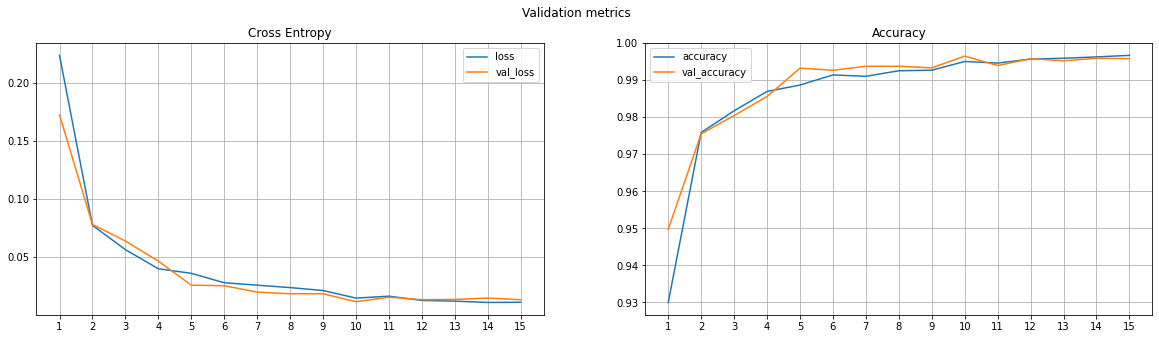

In [10]:
df = pd.DataFrame(H.history)
df.index += 1
fig = plt.figure(figsize = (20,5))
fig.suptitle('Validation metrics')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks(range(len(df)+1))
ax2.set_xticks(range(len(df)+1))
df[['loss', 'val_loss']].plot(title="Cross Entropy", grid=True, ax=ax1)
df[['accuracy', 'val_accuracy']].plot(title="Accuracy",grid=True, ax=ax2)
plt.show()

#### Model serialization

In [11]:
model.save('model.h5', save_format='h5')

#### Predictions

In [12]:
pred = model.predict(test_X)
classes = pred.argmax(axis=-1)

sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = classes
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


 #### Submission

In [13]:
sub.to_csv('submission.csv', index = False)